# Quick Start

[ChemToolsCUDA](https://chemtoolscuda.qcdevs.org/index.html) is suitable for the evaluation of the electron density and its various derivatives of interest for the quantum chemistry community. It offers an easy to use functionality, being highly applicable to larger systems, and can read various popular wave-function formats. This example will illustrate various different post-processing tools that ChemToolsCUDA can be used for.

## Constructing Molecule Object

The first-step is to read the wave-function file and constructing the Molecule class.

In [1]:
from chemtools_cuda import Molecule

file_path = r"./ALA_ALA_0_q000_m01_k00_force_uwb97xd_def2svpd.fchk"
mol = Molecule(file_path)

## Electron Density

The molecule class can efficiently calculate the electron density. These examples will use [Grid](https://grid.qcdevs.org/index.html) package to construct various grids for evaluation.

### Molecular Integration and Dipole Moment

The integration of the electorn density $$\int \rho(\mathbf{r}) d\mathbf{r} = N$$ should provide the total number of electrons. This example will  construct a Becke-Lebedev grid using [MolGrid](https://grid.qcdevs.org/pyapi/grid.molgrid.html) object from grid package using [Hirshfeld](https://grid.qcdevs.org/pyapi/grid.hirshfeld.html) atom-in molecules weights. Additionall, it will calculate the dipole moment of this peptide. 

In [2]:
import numpy as np
from grid.molgrid import MolGrid
from grid.hirshfeld import HirshfeldWeights
from grid.utils import dipole_moment_of_molecule

# Construct Molecular Grid
atom_numbers = mol.numbers     # Atomic numbers
atom_coords = mol.coordinates  # Atomic coordinates
molgrid = MolGrid.from_preset(mol.numbers.astype(int), atom_coords, preset="fine", aim_weights=HirshfeldWeights())

# Calculate density over grid
density = mol.compute_density(molgrid.points)

print(f"Total number of electrons:       {np.sum(atom_numbers)}")
print(f"Integration of electron density: {molgrid.integrate(density)}")

# Calculate Dipole Moment
dipole = dipole_moment_of_molecule(molgrid, density, atom_coords, atom_numbers)

print(f"Dipole Moment: {dipole}")

/home/ali-tehrani/miniconda2/envs/py37/lib/python3.7/site-packages/grid/atomgrid.py:896: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


Total number of electrons:       108
Integration of electron density: 107.99956413601713
Dipole Moment: [-1.19887145  1.57689994 -1.90832791]


### Isosurface and Cube Files

 This example will calculate the isosurface of the electron density. Grid package is used to construct an uniform grid around the molecule from which an isosurface is obtained from [skimage marching cubes](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.marching_cubes) implementation.

In [3]:
from grid.cubic import UniformGrid

grid = UniformGrid.from_molecule(mol.numbers, mol.coordinates, spacing=0.1, extension=8.0)
print(f"Cubic Grid Shape: {grid.shape}")
print(f"Number of Points: {len(grid.points)}")

dens = mol.compute_density(grid.points)

# Optional: Save the cube file
#grid.generate_cube("./density_ALA_ALA.cube", dens, mol.coordinates, mol.numbers)

Cubic Grid Shape: [322 279 218]
Number of Points: 19584684


In [4]:
import numpy as np
from skimage.measure import marching_cubes

# Reshape density to have the cubic shape (N_x, N_y, N_z) for marching cubes
dens = dens.reshape(grid.shape)            

# Run marching cubes algorithm
kverts, kfaces, _, _ = marching_cubes(dens, 0.001, allow_degenerate=False)
kverts = kverts.dot(grid.axes) + grid.origin
print(f"Number of vertices: {len(kverts)}")

# Compute the density again on the isosurface to validate it
dens_iso = mol.compute_density(kverts)
print(f"Mean Density on isosurface: {np.mean(dens_iso)}")
print(f"STD  Density on isosurface: {np.std(dens_iso)}")

Number of vertices: 132542
Mean Density on isosurface: 0.0009981516292339354
STD  Density on isosurface: 1.6994053095993115e-06


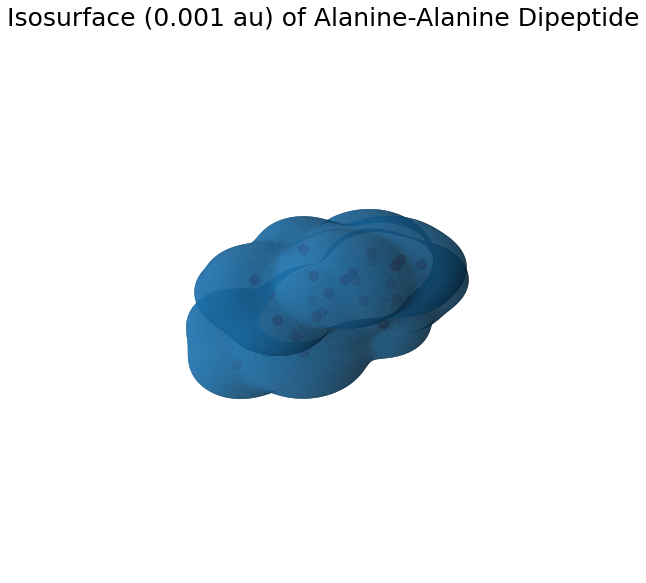

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
ax.plot_trisurf(kverts[:, 0], kverts[:, 1], kverts[:, 2], triangles=kfaces)
ax.scatter(mol.coordinates[:, 0], mol.coordinates[:, 1], mol.coordinates[:, 2], color="r", s=100)
plt.axis("off")
plt.title("Isosurface (0.001 au) of Alanine-Alanine Dipeptide", fontsize=25)
plt.show()


## Reduced Density Gradient

The non-covalent interaction (NCI) method uses the isosurface of reduced density gradient defined as $$ s(\mathbf{r}) = \frac{1}{2(3\pi^2)^{1/3}} \frac{|\nabla \rho(\mathbf{r}) |}{\rho(\mathbf{r})^{4/3}}$$ 

for identifying non-covalent interactions.   This example will illustrate how to use ChemToolsCUDA to find such isosurfaces for the dipeptide example.

In [6]:
import numpy as np
from skimage.measure import marching_cubes
from grid.cubic import UniformGrid
import matplotlib.pyplot as plt
from chemtools_cuda import Molecule

file_path = r"./s02-g01_q-01_m01_k00_force_uwb97xd_def2svpd.fchk"
mol = Molecule(file_path)

# Construct another uniform grid but without a large extension
grid = UniformGrid.from_molecule(mol.numbers, mol.coordinates, spacing=0.03, extension=0.0)

# Calculate the reduced density gradient
rdg = mol.compute_reduced_density_gradient(grid.points)
print(np.mean(rdg), np.std(rdg))
# Remove points whose density cutoff is greater than 0.05
rdg[mol.compute_density(grid.points) > 0.08] = np.inf
# Reshape to match
rdg = rdg.reshape(grid.shape) 

# Find the isosurface of 0.3 a.u.
kverts, kfaces, _, _ = marching_cubes(rdg, 0.3, allow_degenerate=False)
kverts = kverts.dot(grid.axes) + grid.origin
print(f"Number of vertices: {len(kverts)}")

# Compute the density again on the isosurface to validate it
rdg_iso = mol.compute_reduced_density_gradient(kverts)
print(f"Mean Density on isosurface: {np.mean(rdg_iso)}")
print(f"STD  Density on isosurface: {np.std(rdg_iso)}")

1.192454351635232 0.7013961375340325
Number of vertices: 14848
Mean Density on isosurface: 0.29972415519467555
STD  Density on isosurface: 0.0003595601354437498


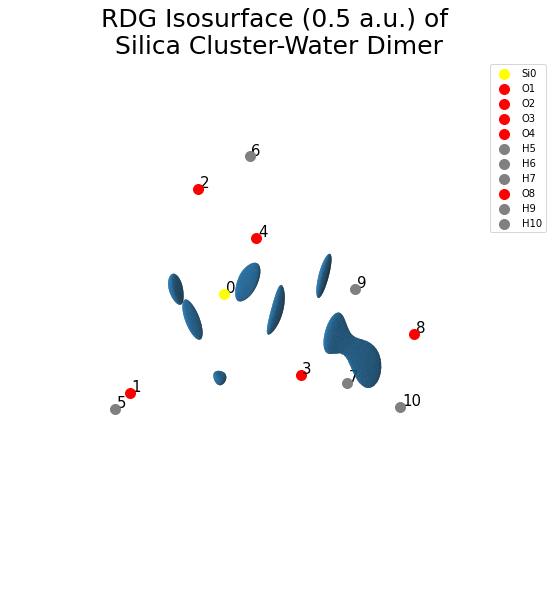

In [7]:
%matplotlib inline

atom_colors = {14: "yellow", 8: "red", 1: "grey", 6: "carbon"}
atom_type = {14: "Si", 8: "O", 6: "C", 1: "H"}

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
ax.plot_trisurf(kverts[:, 0], kverts[:, 1], kverts[:, 2], triangles=kfaces)
for i, (coord, numb) in enumerate(zip(mol.coordinates, mol.numbers)):
    ax.scatter(coord[0], coord[1], coord[2], color=atom_colors[numb], s=100, label=atom_type[numb] + f"{i}")
    ax.text(coord[0]+ 0.03, coord[1]+ 0.03, coord[2] + 0.03, i, fontsize=15)
plt.axis("off")
plt.title("RDG Isosurface (0.5 a.u.) of \n Silica Cluster-Water Dimer ", fontsize=25)
plt.legend()
plt.show()

## NCI Index Using The Hessian 

The sign of the second eigenvalue of the Hessian with the product of its electron density, i.e. $sign(\lambda_2) \rho(\mathbf{r})$, can be used to further classify non-covalent interactions. The sign of the eigenvalues measures how much charge is accumulation in the perpendicular plane of the interaction.  If it is negative, it is an indication of strongly attractive NCI (hydrogen bonds). If it is close to zero, it is a sign of van der Waals interactions and if it is positive it is an example of steric clashes. Following the previous example, here we will see that there is a strongly non-covalent interaction between water molecule and silica cluster.

In [8]:
%matplotlib inline 

# Compute the hessian
hessian = mol.compute_hessian(kverts)
print(f"Shape of the Hessian: {hessian.shape}.")

# Compute the eigenvalues of the Hessian at each point.
eigs = np.linalg.eigvalsh(hessian)
print(f"Shape of the eigenvalues: {eigs.shape}")

# Get the second eigenvalue of each point and compute the classification
eigs = np.sort(eigs, axis=1)[:, 1]
sign_hess = np.sign(eigs) * mol.compute_density(kverts)

Shape of the Hessian: (14848, 3, 3).
Shape of the eigenvalues: (14848, 3)


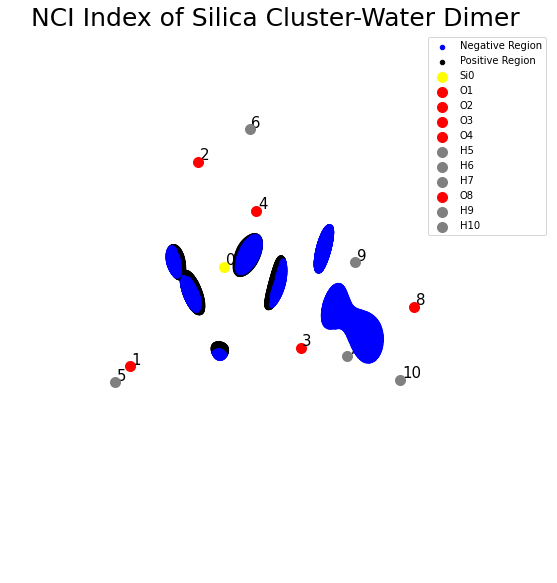

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")
neg = sign_hess < 0.02
ax.scatter(kverts[neg, 0], kverts[neg, 1], kverts[neg, 2], color="b", label="Negative Region")
pos = sign_hess > 0.02
ax.scatter(kverts[pos, 0], kverts[pos, 1], kverts[pos, 2], color="k", label="Positive Region")
for i, (coord, numb) in enumerate(zip(mol.coordinates, mol.numbers)):
    ax.scatter(coord[0], coord[1], coord[2], color=atom_colors[numb], s=100, label=atom_type[numb] + f"{i}")
    ax.text(coord[0]+ 0.03, coord[1]+ 0.03, coord[2] + 0.03, i, fontsize=15)
plt.axis("off")
plt.legend()
plt.title("NCI Index of Silica Cluster-Water Dimer ", fontsize=25)
plt.show()